In [1]:
import os
import numpy as np
import matplotlib as mpl
import cv2 as cv
from numpy import random as rand
from scipy import stats
from matplotlib import pyplot as plt, patches as patch
from skimage import measure as meas, segmentation as seg, color as col, \
                    filters as filt, morphology as morph, feature as feat
from tqdm import tnrange, tqdm_notebook as tqdm
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
# mpl.use('nbAgg')
plt.style.use("seaborn")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (16/2, 9/2)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

In [3]:
class VideoToGraph:
    
    def __init__(self, filename):
        self.filename = filename
        self.frame_store = []
        self.fname = filename[:-4]
        self.fps = 59.94
    
    def trackObject(self):
        frame_store = self.frame_store
        filename = self.filename
        
        cap = cv.VideoCapture(filename)
        cv.namedWindow('VideoToGraph', cv.WINDOW_NORMAL)
        ret, frame1 = cap.read()
        prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
        hsv = np.zeros_like(frame1)
        hsv[...,1] = 255
        while(1):
            ret, frame2 = cap.read()
            if not ret:
                break
            next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
            flow = cv.calcOpticalFlowFarneback(prvs, next, 
                                               flow=None, 
                                               pyr_scale=0.5, 
                                               levels=3, 
                                               winsize=21, 
                                               iterations=3, 
                                               poly_n=7, 
                                               poly_sigma=1.5, 
                                               flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)
            mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
            frame_store.append(mag)
            hsv[...,0] = ang*180/np.pi/2
            hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
            bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
            cv.imshow('VideoToGraph', bgr)
            k = cv.waitKey(30) & 0xff
            if k == 27:
                break
            elif k == ord('s'):
                cv.imwrite('opticalfb.png',frame2)
                cv.imwrite('opticalhsv.png',bgr)
            prvs = next
        cap.release()
        cv.destroyAllWindows()
        self.frame_store = frame_store
    
    def plotObject(self):
        frame_store = self.frame_store
        fps = self.fps
        fname = self.fname
        
        x_avg = []
        for i in range(len(frame_store)):
            x_avg.append(np.argmax(frame_store[i].mean(axis=0)))

        t = np.linspace(0, len(frame_store)/fps, len(frame_store))
        x_avg = np.array(x_avg) * 1e-2
        grad_px = np.array([331.79, 336.16, 305.22, 334.69, 326,80]).mean() * 1e-2
        grad_cm = np.array([11.70, 11.86, 10.77, 11.81, 11.53]).mean() * 1e-2
        s_img = x_avg * grad_cm / grad_px

        dt = t[1] - t[0]
        v_avg = np.zeros_like(s_img)
        for i in range(1, len(s_img)):
            v_avg[1:] = np.diff(s_img)/dt

        fig, (ax1, ax2) = mp.subplots(2, 1, sharex=True)

        ax1.plot(t, s_img, "bo")
        ax1.set_ylabel("Displacement, m")
        ax1.set_title("_".join(fname.split("_")[0:1]) + " " + "_".join(fname.split("_")[1:]))
        ax1.grid(True)
        posname = fname + "_pos.txt"
        np.savetxt(posname, np.array([t, s_img]))

        ax2.plot(t, v_avg, "go")
        ax2.set_xlabel("Time, s")
        ax2.set_ylabel("Velocity, m/s")
        ax2.grid(True)
        velname = fname + "_vel.txt"
        np.savetxt(velname, np.array([t, v_avg]))

        sname = fname + ".png"
        mp.savefig(sname, bbox_inches="tight", dpi=300)
        mp.show()
        
    def run(self):
        self.trackObject()
        self.plotObject()

In [4]:
class ImageSegment:
    
    def __init__(self, image):
        if type(image) == str:
            self.image = cv.imread(image)
        elif type(image) == np.ndarray:
            self.image = image
        else:
            raise NotImplementedError
        self.image_hist = np.squeeze(cv.calcHist([self.image.ravel()], [0], None, [256], [0, 255]))
        eps = 1e-4
#         self.image[np.where(-eps < self.image.all() < eps)[0]] = 1e5
        self.cropping = False
        self.sel_rect_endpoint = None
        self.refpt = None
        
    def BGR2NCC(self, img):
        I = img.sum(axis=2)
        b, g, r = cv.split(img)/I
        return I, r, g

    def pixelLikelihood(self, r, mu, sigma):
        return 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(r - mu)**2/(2 * sigma**2))
    
    def ColorPicker(self, event, x, y, flags, param):
        if event == cv.EVENT_LBUTTONDOWN:
            self.refpt = [(x, y)]
            self.cropping = True
            
        elif event == cv.EVENT_LBUTTONUP:
            self.refpt.append((x, y))
            self.cropping = False

            cv.rectangle(self.image, self.refpt[0], self.refpt[1], (0, 255, 0), 2)
            cv.imshow('macbeth', self.image)
            
        elif event == cv.EVENT_MOUSEMOVE and self.cropping:
            self.sel_rect_endpoint = [(x, y)]
            
    def get_ROI(self):
        image = (self.image/self.image.max()).astype('float32')
        clone = image.copy()
        cv.namedWindow('macbeth', cv.WINDOW_NORMAL)
        if image.shape[0] > image.shape[1]:
            cv.resizeWindow('macbeth', 400, 600)
        else:
            cv.resizeWindow('macbeth', 600, 400)
        cv.setMouseCallback('macbeth', self.ColorPicker)

        while True:
            if not self.cropping:
                cv.imshow('macbeth', self.image)
            elif self.cropping and self.sel_rect_endpoint:
                rect_cpy = image.copy()
                cv.rectangle(rect_cpy, self.refpt[0], self.sel_rect_endpoint[0], (0, 255, 0), 1)
                cv.imshow('macbeth', rect_cpy)
            
            key = cv.waitKey(1) & 0xFF
            if key == ord('r'):
                image = clone.copy()

            elif key == ord('c'):
                break

        if len(self.refpt) == 2:
            self.roi = clone[self.refpt[0][1]:self.refpt[1][1], self.refpt[0][0]:self.refpt[1][0]]
            cv.imshow("ROI", self.roi)
            cv.waitKey(0)

        cv.destroyAllWindows()
    
    def get_chromaROI(self):
        I, r, g = self.BGR2NCC(self.roi)
        self.mu_r, self.sigma_r = np.mean(r), np.std(r)
        self.mu_g, self.sigma_g = np.mean(g), np.std(g)
        
    def get_chromaIMG(self):
        image = (self.image/self.image.max()).astype('float32')
        I, r, g = self.BGR2NCC(image)
        pr = self.pixelLikelihood(r, self.mu_r, self.sigma_r)
        pg = self.pixelLikelihood(g, self.mu_g, self.sigma_g)
        self.combinedHist = pr * pg
        self.param_out = self.combinedHist.copy()
        
    def get_histROI(self, bins=32, plot_hist=False):
        I, r, g = self.BGR2NCC(self.roi)
        rint = (r*(bins-1)).astype('uint8')
        gint = (g*(bins-1)).astype('uint8')
        rg = np.dstack((rint, gint))
        hist = cv.calcHist([rg], [0, 1], None, [bins, bins], [0, bins-1, 0, bins-1])
        if plot_hist:
            mp.figure(figsize=(5, 5))
            cl_hist = np.clip(hist, 0, bins-1)
            mp.imshow(cl_hist, 'gray', origin='lower')
            mp.xlabel('$g$')
            mp.ylabel('$r$')
            mp.grid(0)
            mp.show()
        self.histROI = hist
        self.bins = bins
        
    def get_histIMG(self):
        bins = self.bins
        I, r, g = self.BGR2NCC(self.image)
        rproj = (r*(bins-1)).astype('uint8')
        gproj = (g*(bins-1)).astype('uint8')
        proj_array = np.zeros(r.shape)
        for i in range(r.shape[0]):
            for j in range(r.shape[1]):
                proj_array[i,j] = self.histROI[rproj[i,j], gproj[i,j]]
        self.combinedHist = proj_array
        self.nparam_out = self.combinedHist.copy()
    
    def plot_segment(self):
        fig = plt.figure(figsize=(16, 9))
        
        ax = fig.add_subplot(121)
        ax.imshow(self.image[:,:,::-1])
        ax.axis('off')
        ax.grid(0)
        
        ax = fig.add_subplot(122)
        ax.imshow(self.combinedHist, 'gray')
        ax.axis('off')
        ax.grid(0)

        plt.show()
        
    def parametric(self, **kwargs):
        if self.refpt is None:
            self.get_ROI()
        self.get_chromaROI()
        self.get_chromaIMG()
#         self.plot_segment()
        
    def nonparametric(self, **kwargs):
        if self.refpt is None:
            self.get_ROI()
        self.get_histROI(**kwargs)
        self.get_histIMG()
#         self.plot_segment()

    def otsu(self):
        image = self.image.copy()
        image = (image/image.max() * 255).astype('uint8')
        hist = np.squeeze(cv.calcHist([image], [0], None, [256], [0, 255]))
        total = image.size
        top = 256
        sumB = 0
        wB = 0
        maximum = 0.0
        sum1 = np.arange(top) @ hist
        for i in range(top):
            wF = total - wB
            if wB > 0 and wF > 0:
                mF = (sum1 - sumB) / wF
                val = wB * wF * ((sumB/wB) - mF)**2
                if val >= maximum:
                    level = i
                    maximum = val
            wB += hist[i]
            sumB += i * hist[i]
        self.level = level
        
    def main(self, savename=None, **kwargs):
        self.parametric(**kwargs)
        self.nonparametric(**kwargs)
        if self.image.shape[0] > self.image.shape[1]:
            fig = plt.figure(figsize=(16/2, 9/2))
        else:
            fig = plt.figure(figsize=(16/2*2, 9/2))
        
        ax = fig.add_subplot(131)
        ax.imshow(self.image[:,:,::-1])
        ax.axis('off')
        ax.grid(0)
        ax.set_title('original')
        
        ax = fig.add_subplot(132)
        ax.imshow(self.param_out, 'gray')
        ax.axis('off')
        ax.grid(0)
        ax.set_title('parametric')
        
        ax = fig.add_subplot(133)
        ax.imshow(self.nparam_out, 'gray')
        ax.axis('off')
        ax.grid(0)
        ax.set_title('non-parametric')
        
        plt.tight_layout()
        if savename is not None:
            plt.savefig(savename, dpi=300, bbox_inches='tight')
        plt.show()

## Viscosity

In [146]:
filenames = os.listdir()
for f in filenames:
    if f.endswith('.avi'):
        fn = f[:-4] + '/'
        vid = VideoToGraph(f)
        vid.trackObject()
        for i,v in enumerate(vid.frame_store):
            cv.imwrite(fn + str(i) + '.png', v)

In [203]:
parent_dir = 'castor_28g'
filenames = os.listdir('%s/'%parent_dir)
x_coords = []
for n, f in enumerate(filenames):
    frame = cv.imread('%s/%s.png'%(parent_dir, str(n)), 0)
    thresh, frame = cv.threshold(frame, 127, 255, cv.THRESH_OTSU)
    labeled = meas.label(frame)
    props = meas.regionprops(labeled)
    x_coords.append(props[0]['centroid'][1])

In [204]:
fps = 15
t = np.linspace(0, len(x_coords)/fps, len(x_coords))
x_coords = np.array(x_coords) * 1e-2
grad_px = np.array([331.79, 336.16, 305.22, 334.69, 326,80]).mean() * 1e-2
grad_cm = np.array([11.70, 11.86, 10.77, 11.81, 11.53]).mean() * 1e-2
s_img = x_coords * grad_cm / grad_px

dt = t[1] - t[0]
v_avg = np.zeros_like(s_img)
v_avg[1:] = np.diff(s_img)/dt

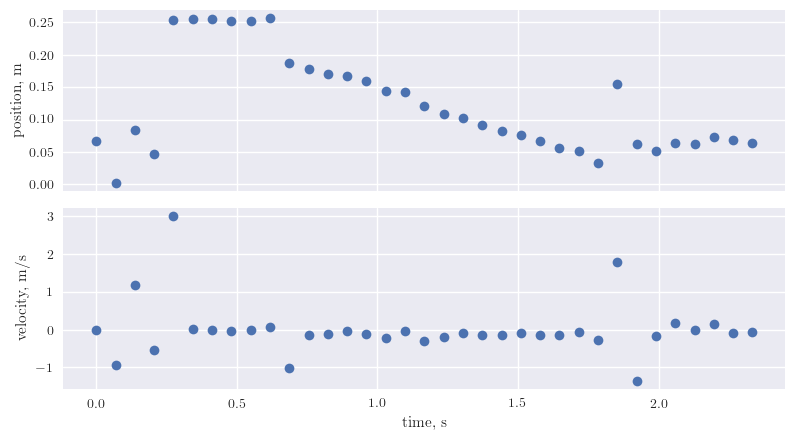

In [222]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16/2, 9/2))

ax[0].plot(t, s_img, 'o')
ax[0].set_ylabel('position, m')

ax[1].plot(t, v_avg, 'o')
ax[1].set_xlabel('time, s')
ax[1].set_ylabel('velocity, m/s')

plt.tight_layout()
plt.show()

## Gravitational acceleration

In [5]:
f = r'D:\Kenneth\Documents\5-1\App Physics 186\Activity 11\KVD_7296.mp4'

In [5]:
vid = VideoToGraph(f)
vid.trackObject()
for i,v in enumerate(vid.frame_store):
    cv.imwrite('7296/' + str(i) + '.png', v)

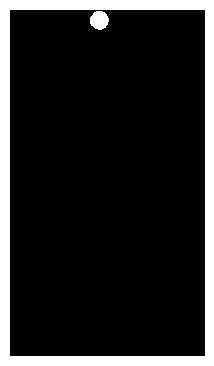

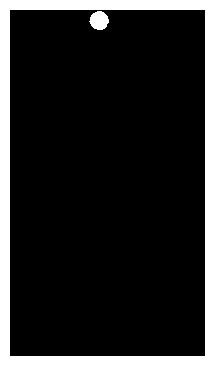

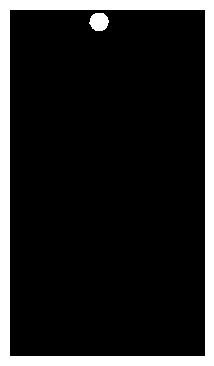

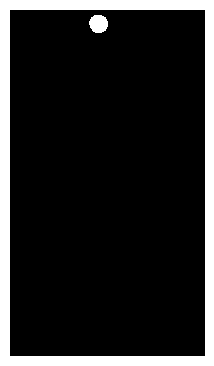

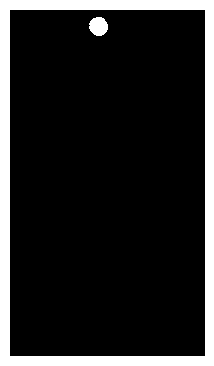

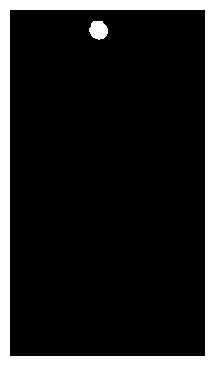

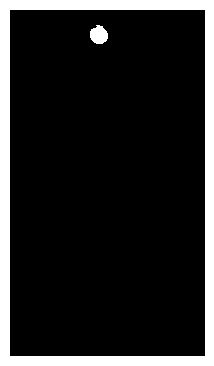

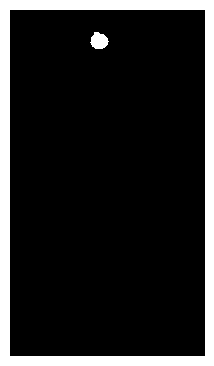

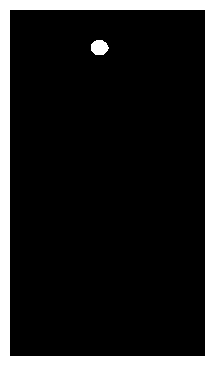

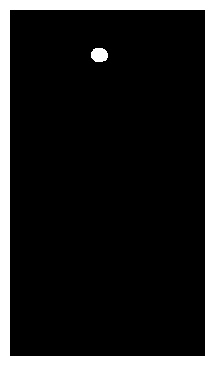

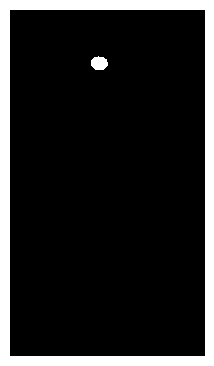

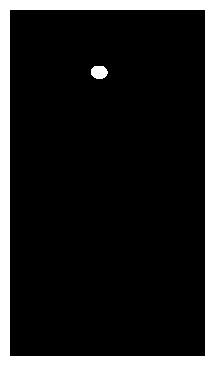

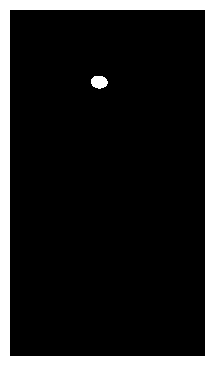

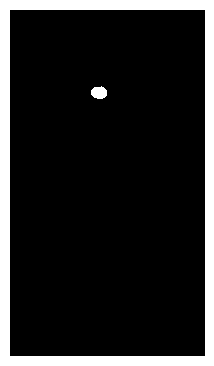

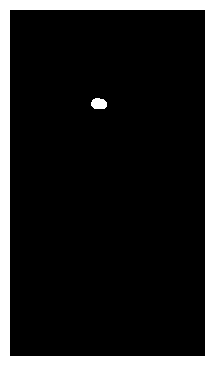

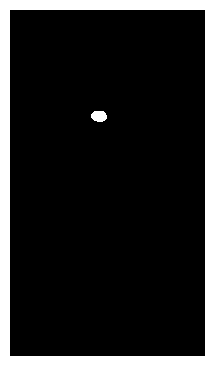

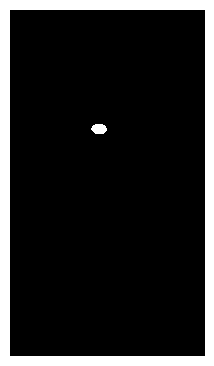

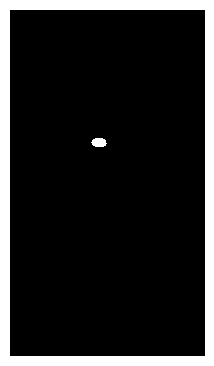

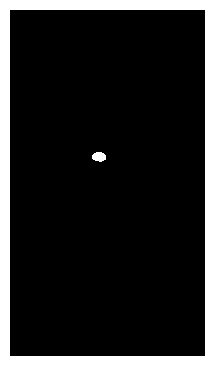

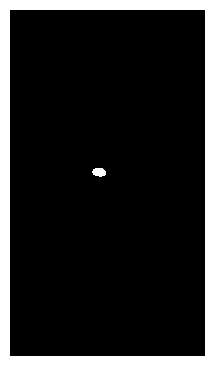

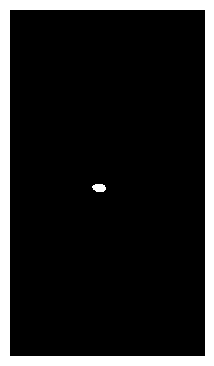

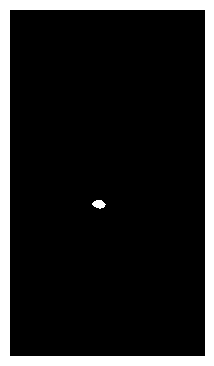

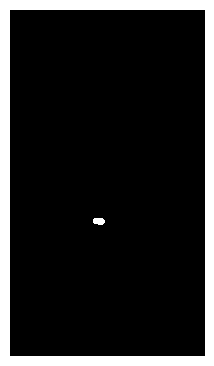

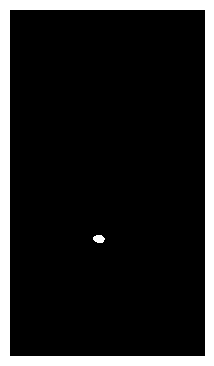

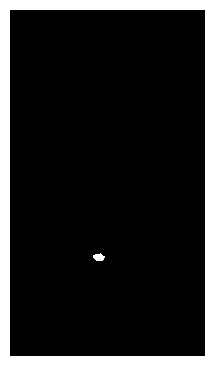

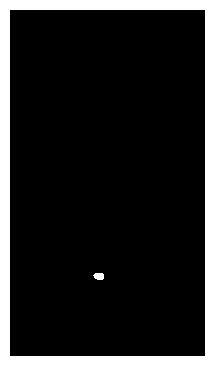

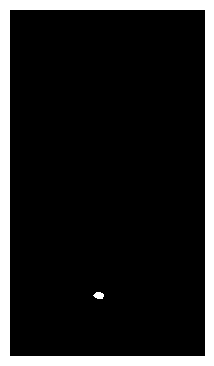

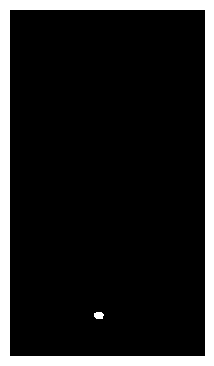

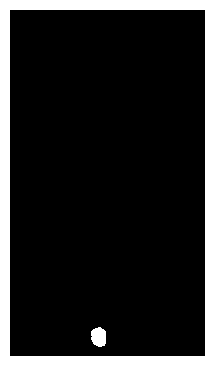

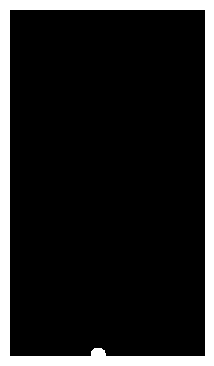

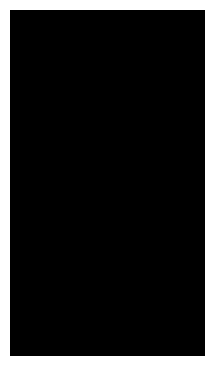

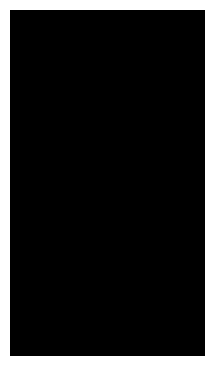

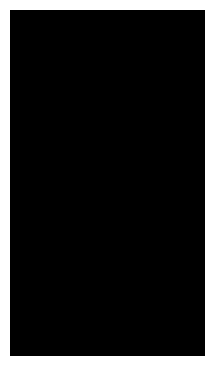

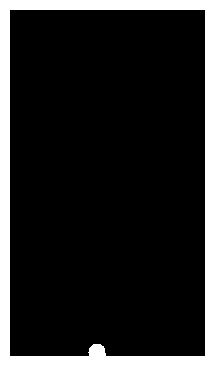

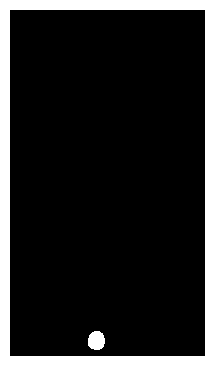

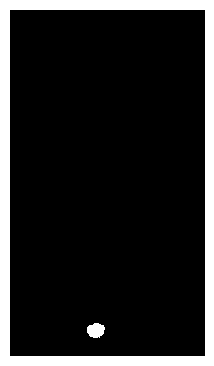

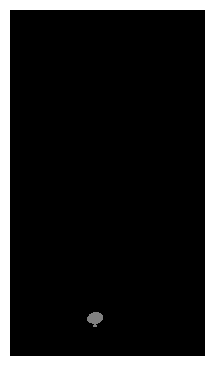

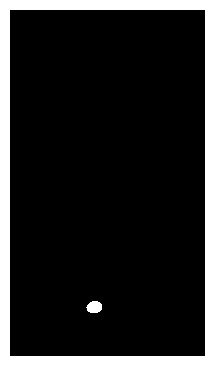

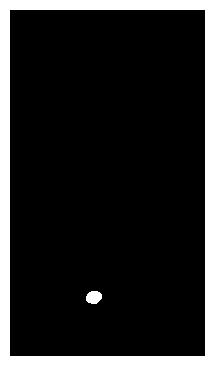

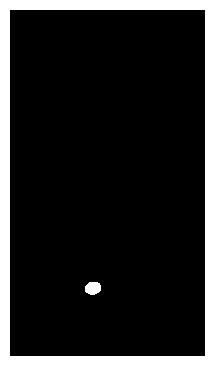

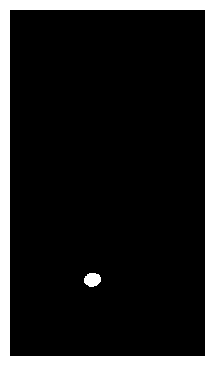

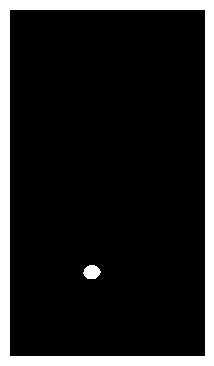

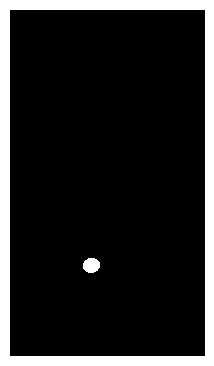

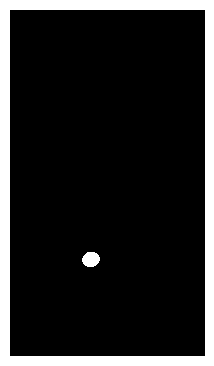

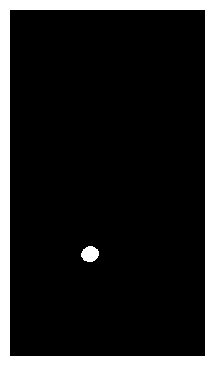

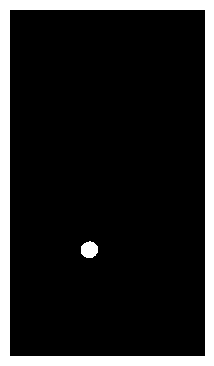

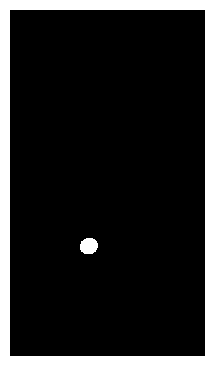

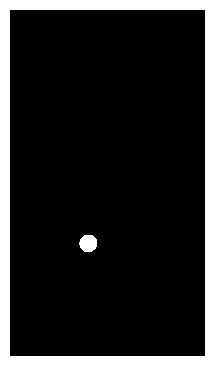

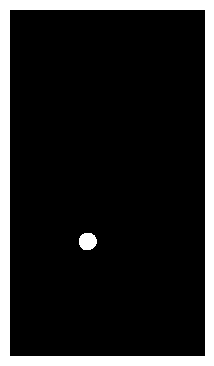

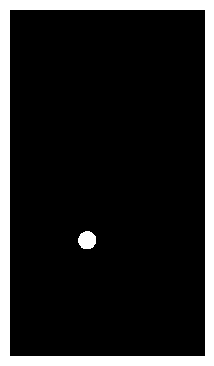

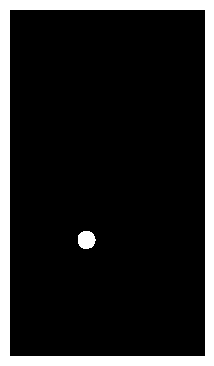

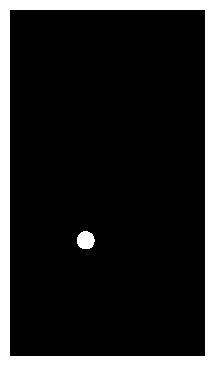

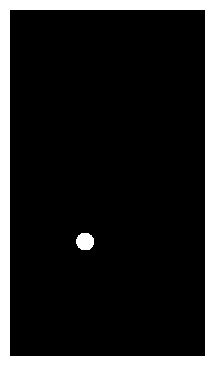

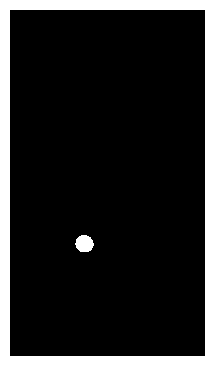

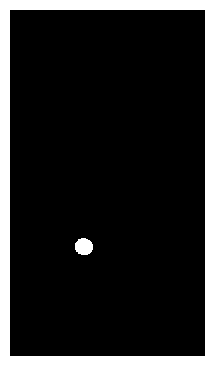

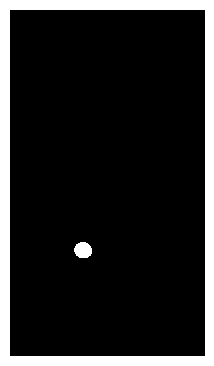

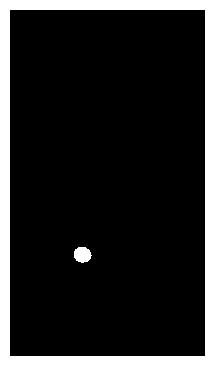

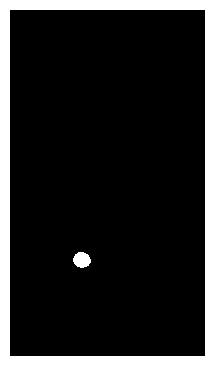

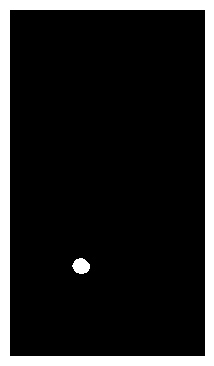

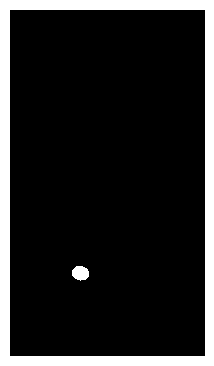

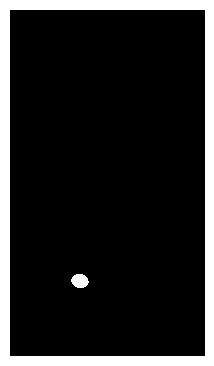

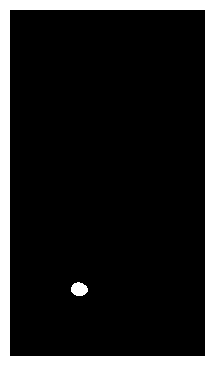

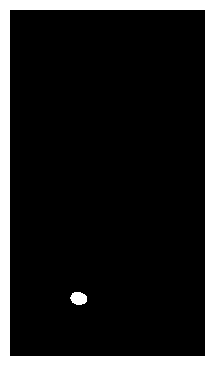

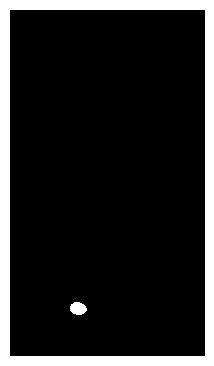

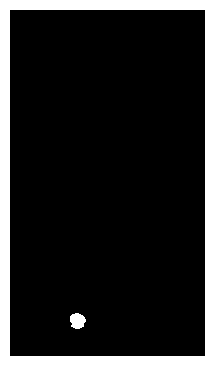

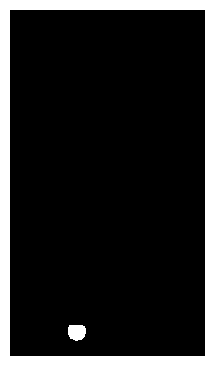

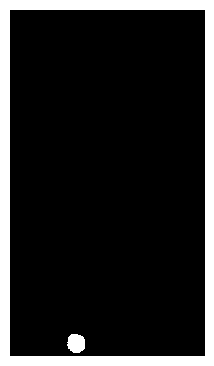

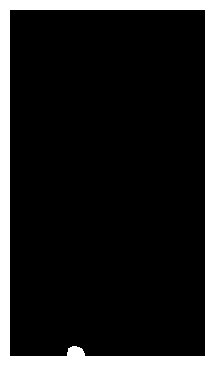

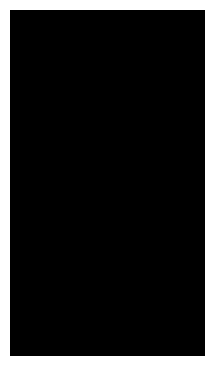

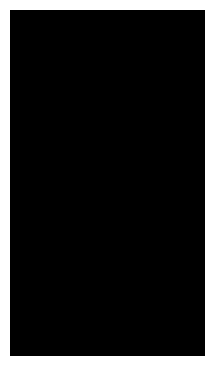

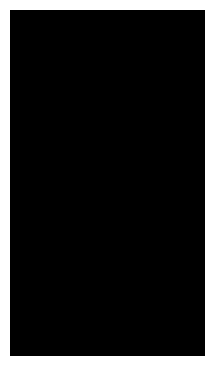

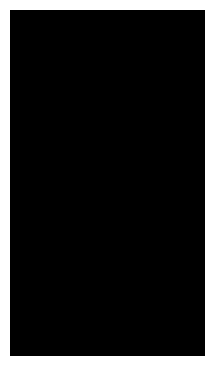

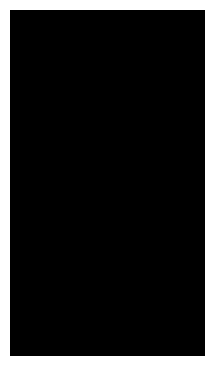

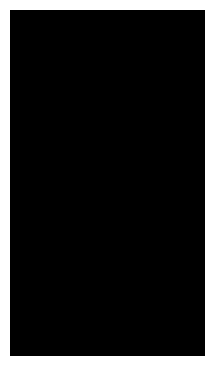

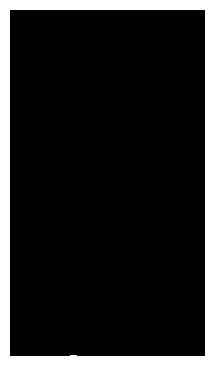

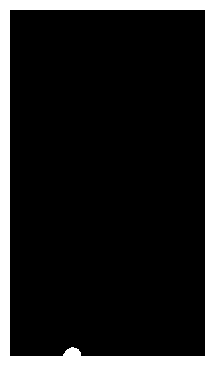

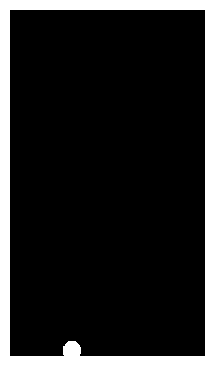

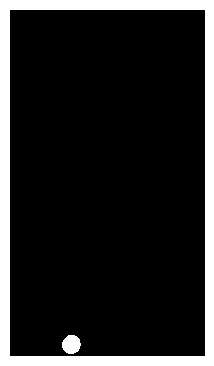

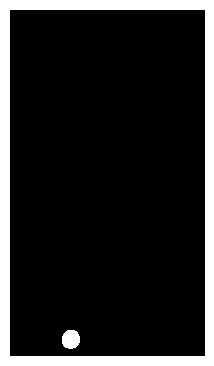

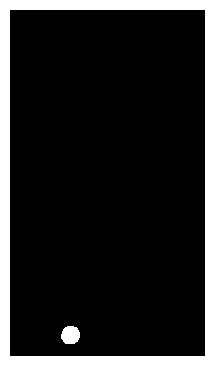

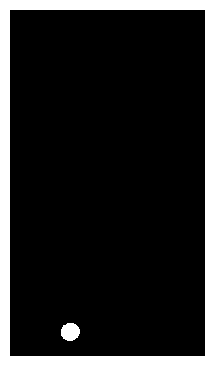

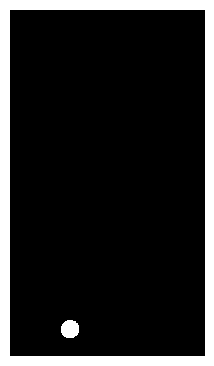

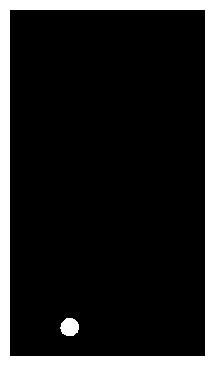

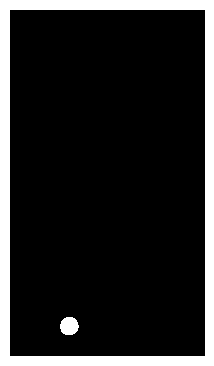

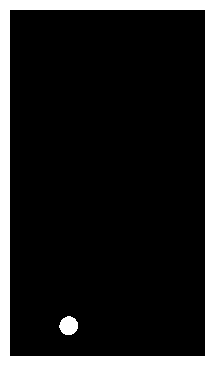

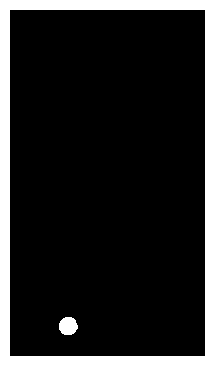

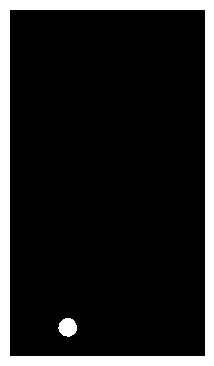

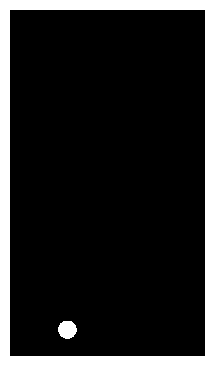

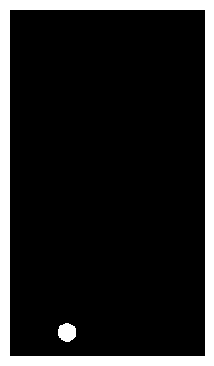

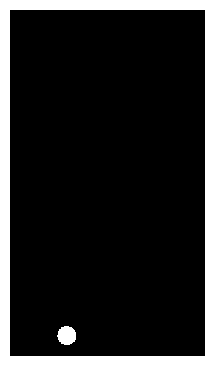

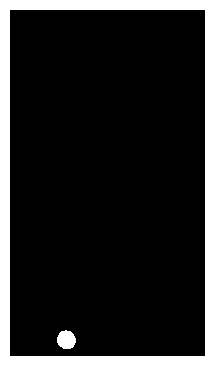

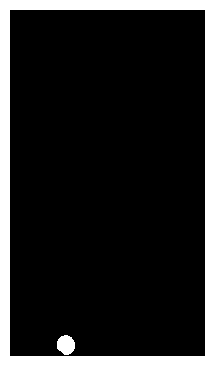

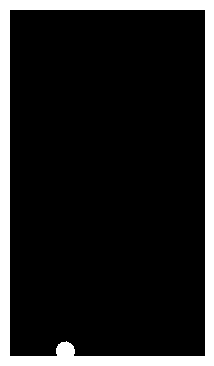

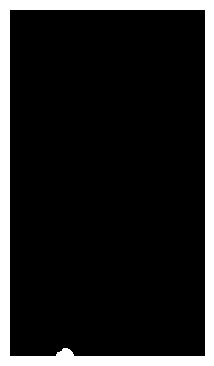

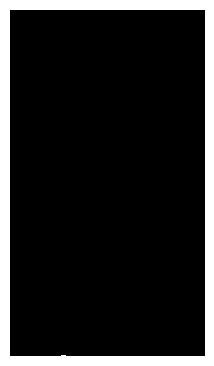

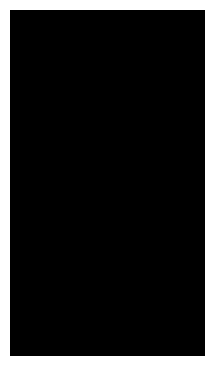

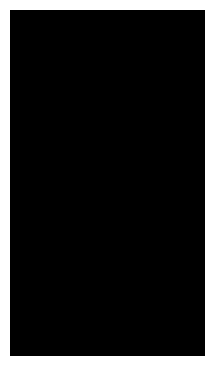

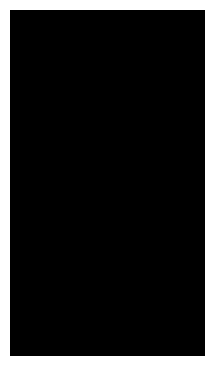

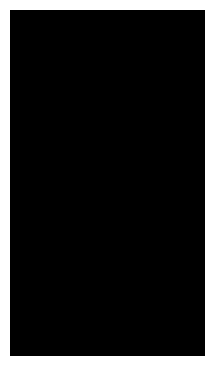

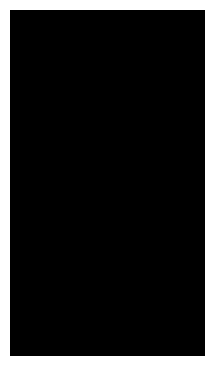

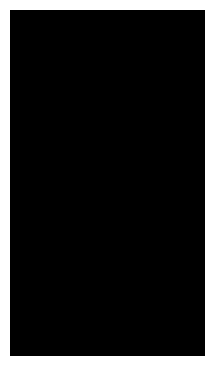

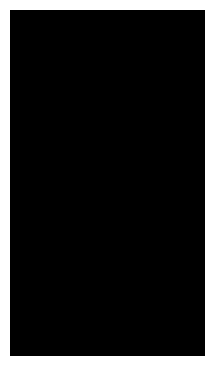

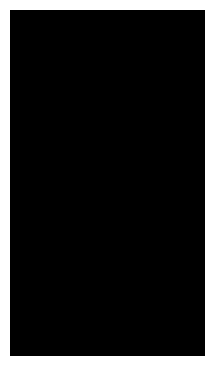

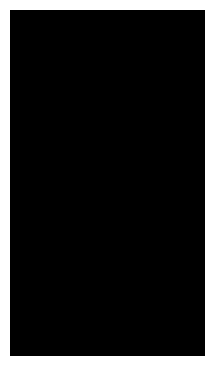

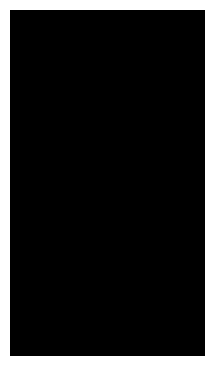

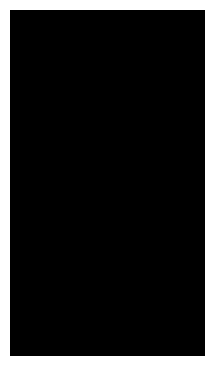

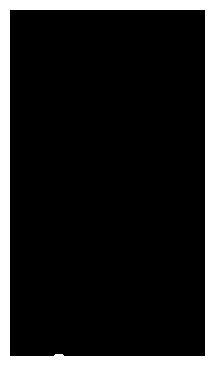

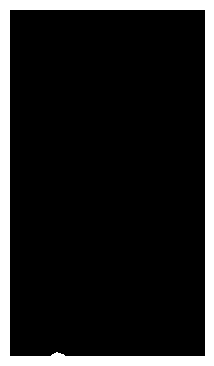

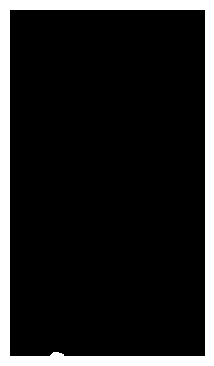

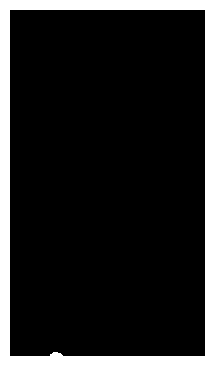

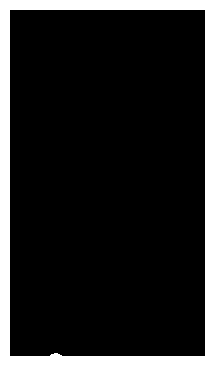

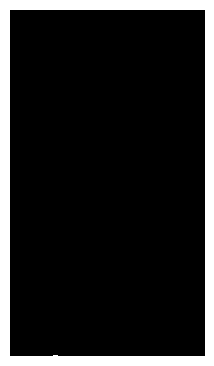

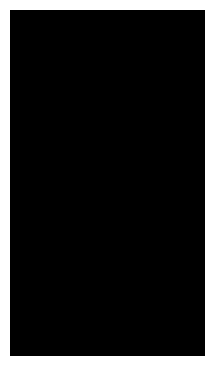

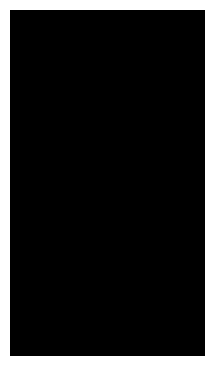

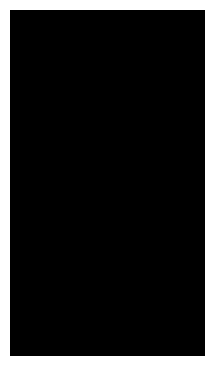

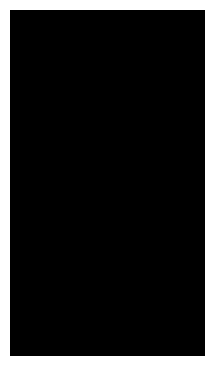

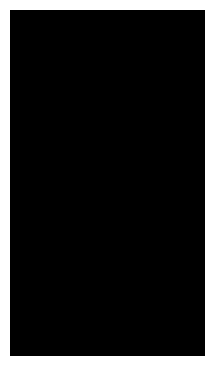

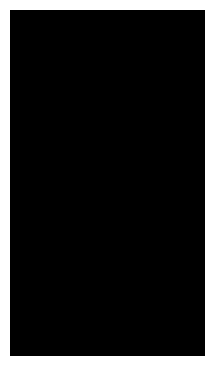

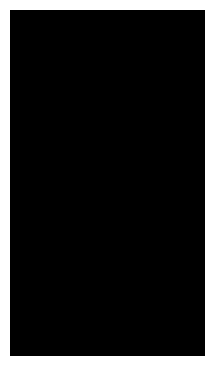

In [6]:
cap = cv.VideoCapture(f)
framebloblist = []
count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if count == 0:
        seg = ImageSegment(frame)
        seg.nonparametric()
    else:
        seg.image = frame
        seg.get_histIMG()
    thres, out = cv.threshold(seg.nparam_out, 127, 255, cv.THRESH_BINARY)
    out = cv.morphologyEx(out, cv.MORPH_CLOSE,
                          cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11)))
    labeled = meas.label(out)
    framebloblist.append(labeled)
    cv.imwrite('7296/%i.png' %count, out)
    plt.imshow(labeled, 'gray')
    plt.axis('off')
    plt.show()
    plt.close('all')
    count += 1

In [22]:
ycoord = []
for i in range(len(framebloblist)):
    props = meas.regionprops(framebloblist[i])
    if len(props) != 0:
        ycoord.append(props[0]['centroid'][0])

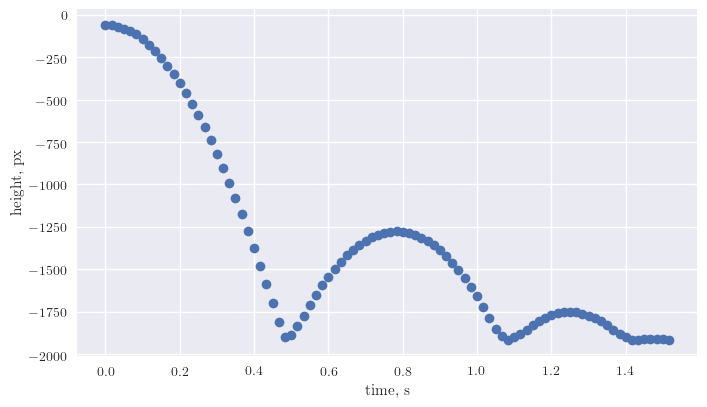

In [32]:
fps = 60
duration = len(ycoord)/fps
t = np.arange(0, duration-1/fps, 1/fps)
plt.plot(t, -np.array(ycoord), 'o')
plt.xlabel('time, s')
plt.ylabel('height, px')
plt.show()